In [1]:
import sys
print(sys.version)

CURR_DIR = '/content/drive/My Drive/google_colab_work/detailed_deep_learning/'
sys.path.append(CURR_DIR)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat import v1 as tf_v1
print(tf.version)
tf.compat.v1.disable_eager_execution()
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
np.random.seed(0)
tf.random.set_seed(1234)

In [17]:
def Inference(x, n_in, n_hiddens, n_out):
    def weight_variable(shape):
        initial = np.sqrt(2.0/shape[0]) * tf.random.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape)
        return tf.Variable(initial)
    
    def batch_normalization(shape, x):
        eps = 1.0e-8
        beta = tf.Variable(tf.zeros(shape))
        gamma = tf.Variable(tf.ones(shape))
        mean, var = tf.nn.moments(x, [0])
        return gamma*(x - mean)/tf.sqrt(var + eps) + beta
    
    for i, n_hidden in enumerate(n_hiddens):
        if i == 0:
            input = x
            input_dim = n_in
        else:
            input = output
            input_dim = n_hiddens[i-1]
    
        W = weight_variable([input_dim, n_hidden])
        h = batch_normalization([n_hidden], tf.matmul(input, W))
        output = tf.nn.relu(h)
    
    W_out = weight_variable([n_hiddens[-1], n_out])
    b_out = bias_variable([n_out])
    y = tf.nn.softmax(tf.matmul(output, W_out) + b_out)
    return y


def Loss(y, t):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.math.log(tf.clip_by_value(y, 1.0e-10, 1.0)), axis=1))
    return cross_entropy


def Training(loss):
    optimizer = tf_v1.train.GradientDescentOptimizer(learning_rate=0.01)
    # optimizer = tf_v1.train.AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step


def Accuracy(y, t):
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(t, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [5]:
mnist = sklearn.datasets.fetch_openml('mnist_784')

In [6]:
print(mnist.data.shape)

(70000, 784)


In [18]:
n = len(mnist.data)
N = 30000
N_train = 20000
N_valid = 4000
indices = np.random.permutation(range(n))[:N]

X = mnist.data[indices]
t = mnist.target[indices]
T = np.eye(10)[t.astype(int)]

X_train, X_test, T_train, T_test = train_test_split(X, T, train_size=N_train)
print('X_train.shape =', X_train.shape, ', X_test.shape =', X_test.shape)

X_train, X_valid, T_train, T_valid = train_test_split(X_train, T_train, test_size=N_valid)
print('X_train.shape =', X_train.shape, ', X_valid.shape =', X_valid.shape)

X_train.shape = (20000, 784) , X_test.shape = (10000, 784)
X_train.shape = (16000, 784) , X_valid.shape = (4000, 784)


In [19]:
n_in = len(X[0])
n_hiddens = [200, 200, 200]
n_out = len(T[0])

x = tf_v1.placeholder(tf.float32, shape=[None, n_in])
y = Inference(x, n_in, n_hiddens, n_out)
t = tf_v1.placeholder(tf.float32, shape=[None, n_out])

loss = Loss(y, t)
train_step = Training(loss)
accuracy = Accuracy(y, t)

history = {
    'valid_loss': [],
    'valid_acc': []
}

In [20]:
epochs = 50
batch_size = 200
n_batches = N_train // batch_size

init = tf_v1.global_variables_initializer()
sess = tf_v1.Session()
sess.run(init)

for epoch in range(epochs):
    X_shuffle, T_shuffle = sklearn.utils.shuffle(X_train, T_train)

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size

        sess.run(train_step, feed_dict={
            x: X_shuffle[start:end],
            t: T_shuffle[start:end],
        })

    valid_loss = loss.eval(session=sess, feed_dict={
        x: X_valid,
        t: T_valid
    })

    valid_acc = accuracy.eval(session=sess, feed_dict={
        x: X_valid,
        t: T_valid
    })

    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)

    if epoch % 10 == 0:
        print('epoch =', epoch, ', valid_loss =', valid_loss, ', valid_acc =', valid_acc)

epoch = 0 , valid_loss = 0.60143787 , valid_acc = 0.84675
epoch = 10 , valid_loss = 0.08430575 , valid_acc = 0.97875
epoch = 20 , valid_loss = 0.07679613 , valid_acc = 0.98075
epoch = 30 , valid_loss = 0.07428871 , valid_acc = 0.9805
epoch = 40 , valid_loss = 0.07911603 , valid_acc = 0.9795


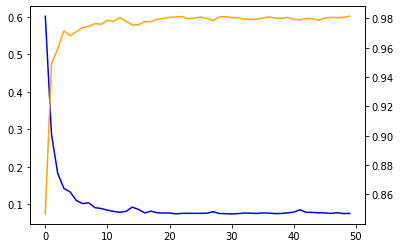

In [21]:
fig = plt.figure()
ax_loss = fig.add_subplot(1,1,1)
ax_loss.plot(range(epochs), history['valid_loss'], label='valid_loss', color='blue')
ax_acc = ax_loss.twinx()
ax_acc.plot(range(epochs), history['valid_acc'], label='valid_acc', color='orange')
plt.xlabel('epochs')
plt.show()

In [22]:
accuracy_rate = accuracy.eval(session=sess, feed_dict={
    x: X_test,
    t: T_test
})

print('accuracy_rate =', accuracy_rate)

accuracy_rate = 0.9776
